<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training a Multi-Object Tracking Model

In this notebook, we give an introduction to training a multi-object tracking model using [torchvision](https://pytorch.org/docs/stable/torchvision/index.html). Using a small dataset, we demonstrate how to train and evaluate a one-shot multi-object tracking model, which detects objects and learns their re-ID features. In particular, we will use [FairMOT](https://github.com/ifzhang/FairMOT) which is a state-of-the-art tracking model with high accuracy and inference speed. We will train the model on a set of still images, then evaluate on a video.  

To learn more about how multi-object tracking works, visit our [FAQ](./FAQ.md)

## Initialization
Import all the functions we need.

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Regular Python Libraries
import os
import os.path as osp
import sys

# Third party tools
from IPython.display import Video as video2
from ipywidgets import Video
import matplotlib.pyplot as plt
import torch
import torchvision

# Computer Vision repository
sys.path.append("../../")
from utils_cv.common.data import data_path, download, unzip_url
from utils_cv.common.gpu import which_processor, is_windows
from utils_cv.tracking.data import Urls
from utils_cv.tracking.dataset import TrackingDataset
from utils_cv.tracking.model import TrackingLearner
from utils_cv.tracking.plot import play_video, write_video

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0a0+6b959ee
Torch is using GPU: Tesla K80


This shows your machine's GPUs (if it has any) and the computing device `torch/torchvision` is using.

Next, set some training and inference parameters, as well as the data input parameters.

In [3]:
# training params
EPOCHS = 3
LEARNING_RATE = 0.0001
BATCH_SIZE = 1
MODEL_PATH = (
    "./models/all_dla34.pth"  # the path of the pretrained model to finetune/train
)
TRAINED_MODEL_PATH = "./models/all_dla34_ft0701.pth"  # the path of the pretrained model to finetune/train
SAVE_MODEL = True

# inference params
CONF_THRES = 0.3
TRACK_BUFFER = 300

# data
TRAIN_DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EVAL_DATA_PATH = unzip_url(Urls.carcans_annotations_path, exist_ok=True)

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")

Using torch device: cuda


## Prepare Training Dataset

For the training data, we use a toy dataset called *Fridge Objects*, which consists of 134 images of 4 classes of beverage container `{can, carton, milk bottle, water bottle}` photos taken on different backgrounds, as used for the object detection scenario. This will serve as a illustration of how one can finetune a pre-trained tracking model with a small training data.

Similar to the object detection [training introduction notebook](../detection/01_training_introduction.ipynb), in the above cell, we use the helper function `unzip_url` to download and unzip data set to the `ComputerVision/data` directory.

In [5]:
os.listdir(TRAIN_DATA_PATH)

['images', 'labels_with_ids', '.ipynb_checkpoints']

You'll notice that we have two different folders inside:
- `/images/`
- `/labels_with_ids/`

This format of having 2 folders, one for images and one for labels, is fairly common for object detection and object tracking. Compared to object detection, for object tracking, the 'labels_with_ids' files have a field for the id number. 

```
/data
+-- images
|   +-- 00001.jpg
|   +-- 00002.jpg
|   +-- ...
+-- labels_with_ids
|   +-- 00001.txt
|   +-- 00002.txt
|   +-- ...
+-- ...
```

Each image corresponds to a txt file, which must have a similar name, e.g. txt file '00128.txt' contains detections and tracking  information in image file '00128.jpg', i.e. it contains the bounding boxes and the object ids information. In this example, our fridge object dataset is annotated in the format followed by the [FairMOT repo](https://github.com/ifzhang/FairMOT), originally from the [Towards-Realtime-MOT repo](https://github.com/Zhongdao/Towards-Realtime-MOT/blob/master/DATASET_ZOO.md). For example, '00128.txt' contains the following:

```
0 3 0.35671 0.50450 0.17635 0.23724
0 2 0.67335 0.49399 0.36874 0.57057

```
This follows the FairMOT file format, where each line describes a bounding box as follows, as described in [Towards-Realtime-MOT repo](https://github.com/Zhongdao/Towards-Realtime-MOT/blob/master/DATASET_ZOO.md):
```
[class] [identity] [x_center] [y_center] [width] [height]
```
The field `class` is set to 0, for all, as only single-class multi-object tracking is currently supported by the [FairMOT repo](https://github.com/ifzhang/FairMOT). The field `identity` is an integer from `0` to `num_identities - 1`. In this training dataset, we used this dictionary to convert the original class-labels to ids: `{'milk_bottle': 0, 'water_bottle': 1, 'carton': 2, 'can': 3}`. The values of ` [x_center] [y_center] [width] [height]` are normalized by the width/height of the image, and range from `0` to `1`. 

## Load Training Images

To load the data, we create a `TrackingDataset` object which knows how to read our images and annotations.

In [4]:
data_train = TrackingDataset(TRAIN_DATA_PATH, batch_size=BATCH_SIZE)

## Finetune a Pretrained Model

For the TrackingLearner, we use FairMOT's baseline tracking model. FairMOT's baseline tracking model is pre-trained on pedestrian datasets, such as in the [MOT challenge datasets](https://motchallenge.net/). Hence, it does not even detect fridge objects, such as in the video we will use for evaluation.

When we initialize the TrackingLearner, we can pass in the training dataset and the path to which the trained 
model will be saved. By default, we use the baseline FairMOT model, which must be downloaded [here](https://drive.google.com/file/d/1udpOPum8fJdoEQm6n0jsIgMMViOMFinu/view) and saved to `./models` as `all_dla.pth`. 

In [5]:
tracker = TrackingLearner(data_train, MODEL_PATH)

To run the training, we call the `fit` method in the tracker object.

In [6]:
tracker.fit(num_epochs=EPOCHS, lr=LEARNING_RATE)

loaded ./models/all_dla34.pth, epoch 10
=====  Epoch: 1/3  =====


/data/anaconda/envs/cv/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss: 3.3081671241670847
hm_loss: 0.44315824198323145
wh_loss: 2.334792869126735
off_loss: 0.21383720044589913
id_loss: 1.3483365800542135
time: 6.516666666666667
=====  Epoch: 2/3  =====
loss: 1.2869463715081413
hm_loss: 0.07476917327858246
wh_loss: 1.5550298977759667
off_loss: 0.19461236971013327
id_loss: 0.9699238012544811
time: 6.55
=====  Epoch: 3/3  =====
loss: 1.002684934064746
hm_loss: 0.04573048518765669
wh_loss: 1.5780630639055744
off_loss: 0.18610322831712742
id_loss: 0.8494142877558867
time: 6.55


We can now visualize the training losses computed in each training epoch, and see how the model improves with training. We want to run the training for an appropriate `num_epochs` and `lr` (to be fine-tuned by the user) that produces a loss-curve that tails off. The loss-curve for our training is as follows:

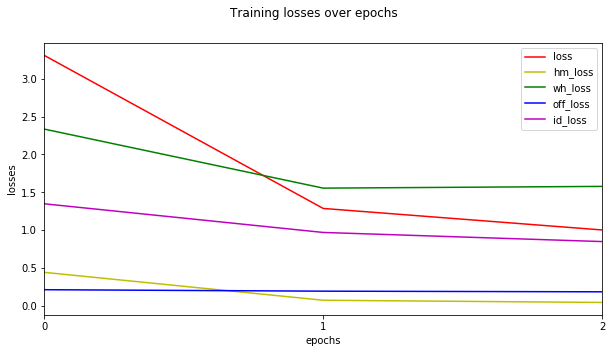

In [8]:
tracker.plot_training_losses()

# Predict and Evaluate Tracking
To validate the trained model, we want to run it on an evaluation dataset and compare the predicted tracking results with the dataset's ground-truth annotations. 

As evaluation dataset, we will be using the following video, for which we have annotated and stored each frame in path `EVAL_DATA_PATH`. For more details on how to prepare the annotation and evaluation dataset in the correct format, please see the  [FAQ](./FAQ.md). 

In [26]:
# TODO: Patrick upload video carcans_1s
eval_video = download(
    Urls.carcans_1s_video_path, os.path.join(data_path(), "carcans_eval.mp4")
)
# eval_video = "./data/carcans_1s.mp4"
Video.from_file(eval_video)

Video(value=b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00mp41isom\x00\x00\x00(uuid\\\xa7\x08\xfb2\x8eB\x05\xa8ae\…

## Predict

Now, we can run the `predict` function on our evaluation dataset.

Note that there are several parameters that can be tweaked to improve the tracking performance and inference speed, including `conf_thres`, `track_buffer`, please see the  [FAQ](./FAQ.md) for more details. 

In [92]:
eval_results = tracker.predict(
    EVAL_DATA_PATH, conf_thres=CONF_THRES, track_buffer=TRACK_BUFFER,
)

loaded ./models/all_dla34_ft0701.pth, epoch 3


`predict` returns `eval_results`, a dictionary where each key is a the frame number, and the value is a list of `TrackingBbox` objects, which represent the tracking information of each object detected, i.e. bounding boxes and tracking ids. For example, when we print out the tracking results from the last frame (frame 30), we can see 2 objects being tracked:

In [67]:
print("Last frame...tracking result:", eval_results[max(eval_results.keys())])

Last frame...tracking result: [{Bbox object: [left=624, top=259, right=734, bottom=431] | frame: 30 | track: 1}, {Bbox object: [left=866, top=200, right=965, bottom=347] | frame: 30 | track: 3}]


We can now visualize the tracking results, with the bounding boxes and id of the tracked objects overlaid onto the video:

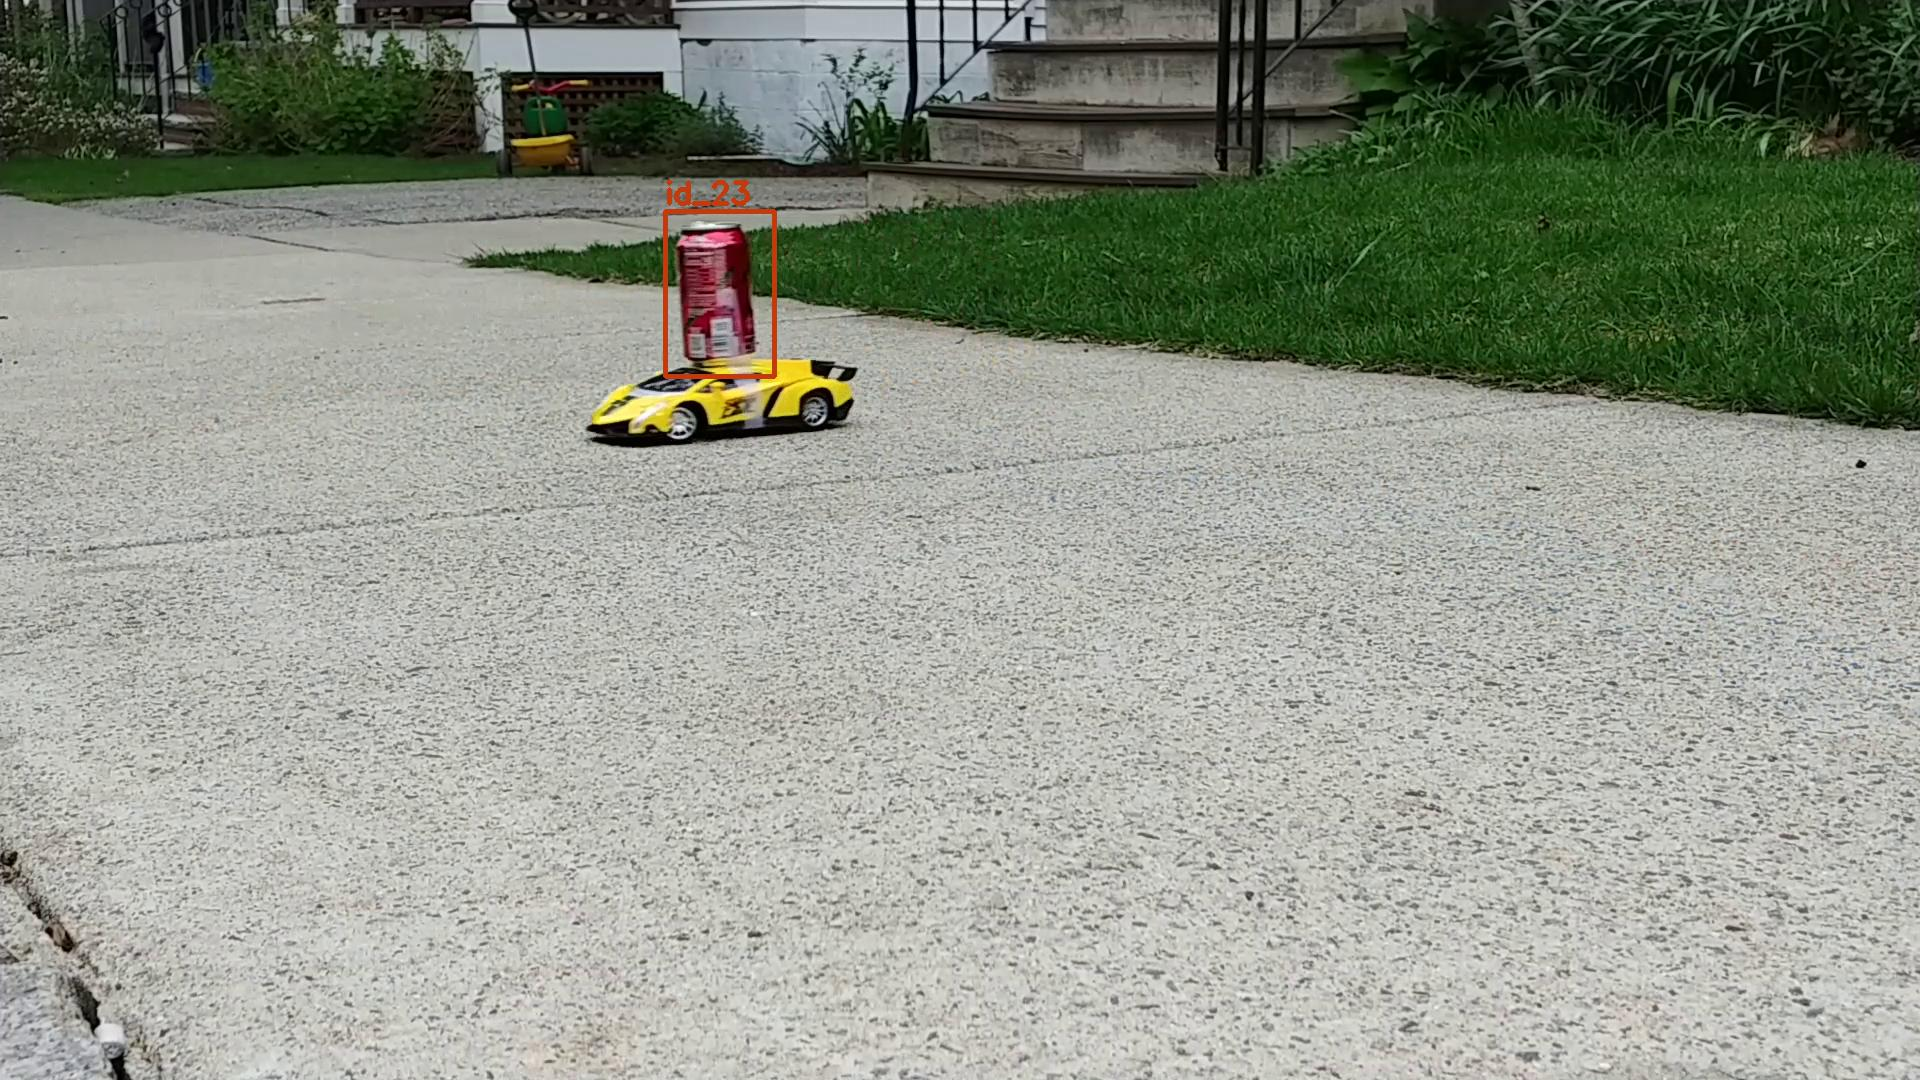

In [68]:
play_video(eval_results, eval_video)

 We now save the resulting video, which you can download at the path set below.

In [78]:
eval_results_video = osp.join(data_path(), "01_evalvid_tracked.mp4")
write_video(eval_results, eval_video, eval_results_video)

Output saved to /data/home/maidapmot/blob_karineMOT/computervision-recipes/data/01_evalvid_tracked.mp4.


## Evaluate

We can simply pass on our `tracking_results` to the `evaluate` method in our tracker to evaluate the results. Additionally, we pass on the path of the ground-truth data, on which we can run the evaluation. The result output is the standard MOT metrics, e.g. MOTA, IDF1 etc, which give a measure of different aspects of the tracking performance. Refer to the [FAQ](./FAQ.md) for more details on MOT metrics.

In [77]:
eval_metrics = tracker.evaluate(eval_results, EVAL_DATA_PATH)
print(eval_metrics)

            IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML FP FN IDs  FM MOTA  MOTP IDt IDa IDm
single_vid 50.9% 55.8% 46.0% 44.4% 54.9%  2  0  2  0 23 35   0  14 7.9% 0.366   0   0   0
OVERALL    50.9% 55.8% 46.0% 44.4% 54.9%  2  0  2  0 23 35   0  14 7.9% 0.366   0   0   0


## Save the trained model
We can iterate over the training and evaluation section till satisfied with the training and evaluation results. We can save the final finetuned model to disk:

In [ ]:
if SAVE_MODEL:
    tracker.save(TRAINED_MODEL_PATH)

# Predict Tracking on New Video

We can also use the saved retrained tracking model to predict tracking in a new video, without outputting evaluation. For illustration, we will use the following 8s video:

In [53]:
test_video = download(Urls.carcans_video_path, os.path.join(data_path(), "carcans.mp4"))
Video.from_file(test_video)

Video(value=b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00mp41isom\x00\x00\x00(uuid\\\xa7\x08\xfb2\x8eB\x05\xa8ae\…

We load our saved trained model into our `TrackingLearner` object, and run the `predict` function on the new video:

In [84]:
tracker = TrackingLearner(None, TRAINED_MODEL_PATH)
test_results = tracker.predict(
    test_video, conf_thres=CONF_THRES, track_buffer=TRACK_BUFFER,
)

loaded ./models/all_dla34_ft0701.pth, epoch 3


Let's visualize the tracking results, with the bounding boxes and id of the tracked objects overlaid onto the video:

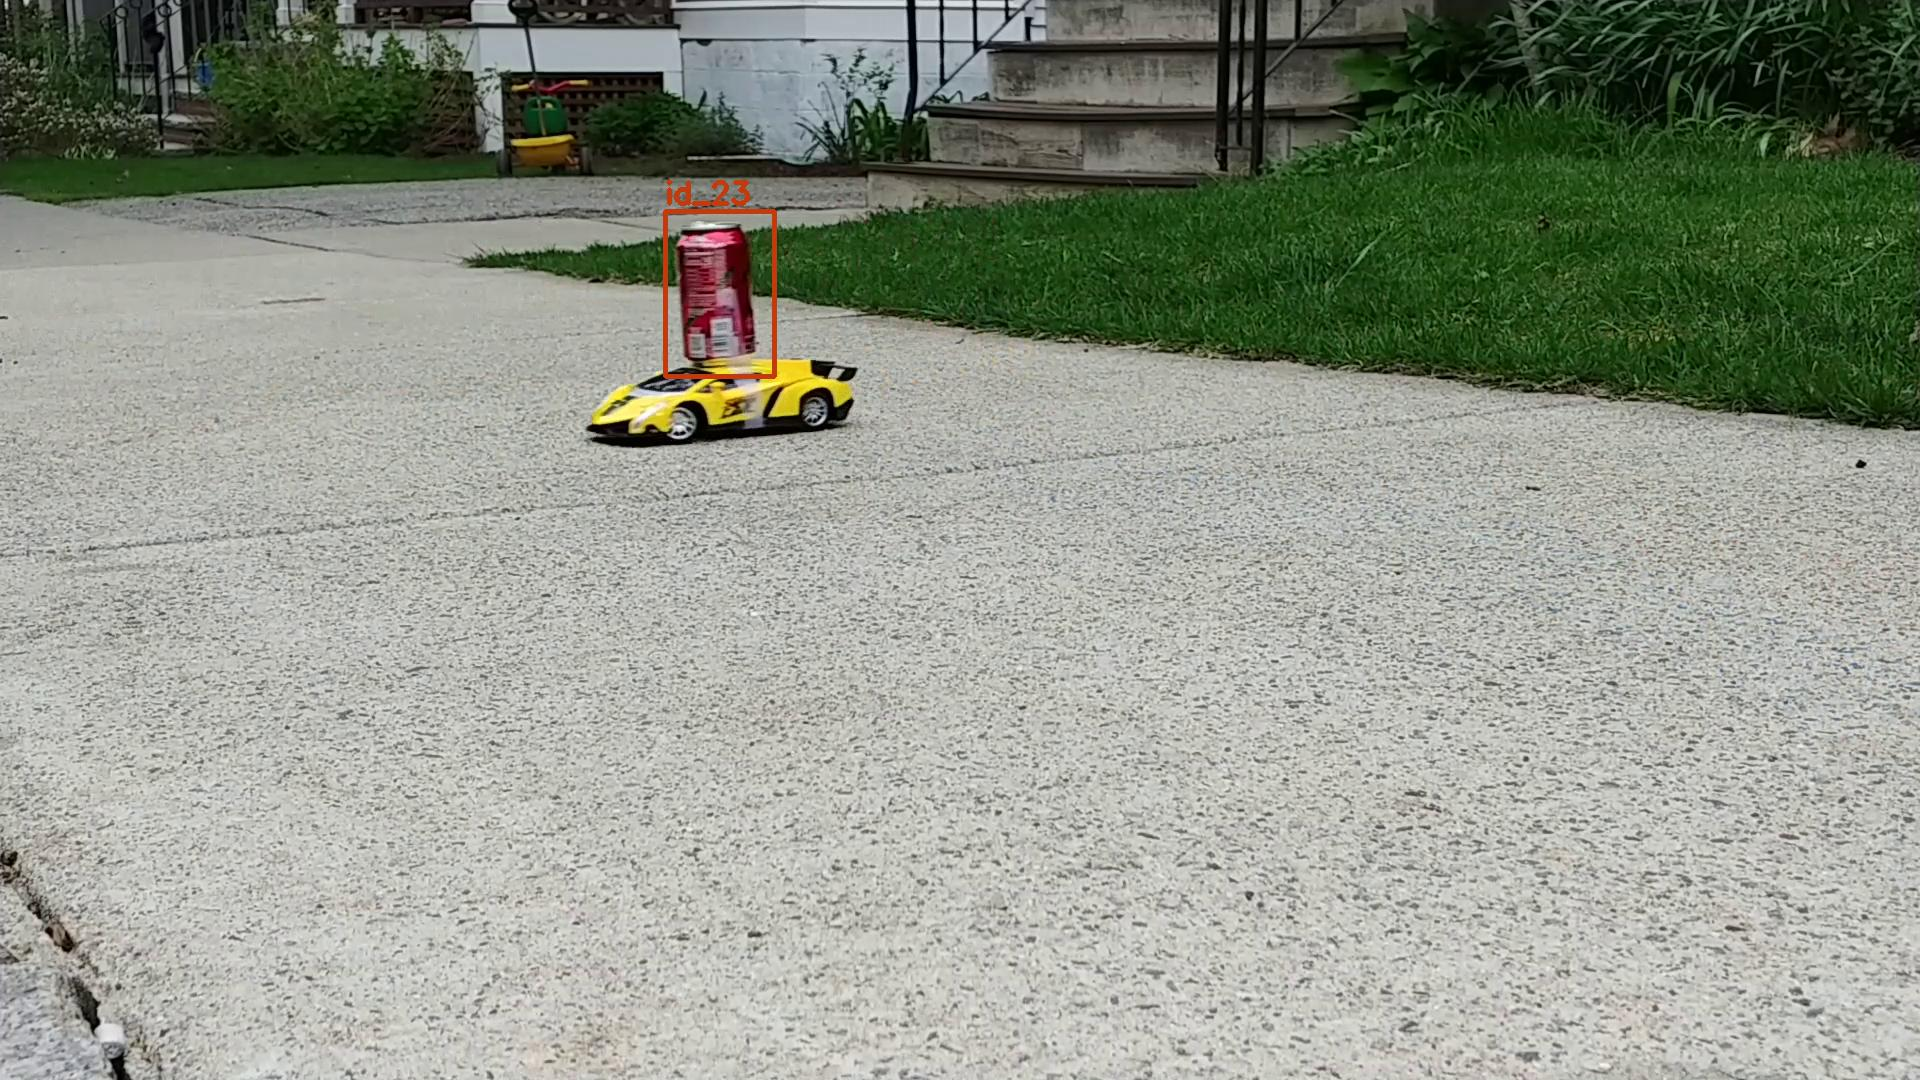

In [85]:
play_video(test_results, test_video)

 We now save the resulting video, which you can download at the path set below.

In [79]:
test_results_video = osp.join(data_path(), "01_testvid_tracked.mp4")
write_video(test_results, test_video, test_results_video)

Output saved to /data/home/maidapmot/blob_karineMOT/computervision-recipes/data/01_testvid_tracked.mp4.
